In [3]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import re
from random import randint, seed
from IPython.display import display
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
pd.set_option('display.max_columns', None)
#import plotly.express as px

C:\Users\rapha\AppData\Local\Temp\ipykernel_800\2317639152.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import du dataset

In [4]:
path = 'maladie_cardiaque.csv'
maladie = pd.read_csv(path,sep=',',header=0, index_col=1)
maladie = maladie.drop(columns=['Unnamed: 0'])
maladie.head(5)

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade
id,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non


# Analyse superficielle du dataset

In [5]:
from data_analyzer import analyse

resultat = analyse(maladie)
display(resultat)

(70000, 12)

,Name,dtypes,Missing,Miss_Percent,Unique,First Value,Second Value,Third Value
0,age,int64,0,0.0,8076,18393,20228,18857
1,genre,object,0,0.0,2,homme,femme,femme
2,taille,int64,0,0.0,109,168,156,165
3,Poids,float64,0,0.0,287,62.0,85.0,64.0
4,pression_systo,int64,0,0.0,153,110,140,130
5,pression_diasto,int64,0,0.0,157,80,90,70
6,cholesterol,object,0,0.0,3,normal,tres eleve,tres eleve
7,glycemie,int64,0,0.0,3,1,1,1
8,fumeur,object,0,0.0,2,non fumeur,non fumeur,non fumeur
9,conso_alco,object,0,0.0,2,non,non,non


In [6]:
maladie.describe()

,age,taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,1.226457,0.803729
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.572270,0.397179
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,1.000000


# Data Prep

Création d'une colonne pour avoir l'âge en année

In [7]:
maladie["Age(year)"] = maladie["age"]/365

Ajout d'une colonne avec l'IMC des individus

In [8]:
maladie["IMC"] = maladie['Poids']/((maladie['taille']/100)*(maladie['taille']/100))
maladie

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age(year),IMC
id,,,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,50.391781,21.967120
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,55.419178,34.927679
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,51.663014,23.507805
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,48.282192,28.710479
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,47.873973,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,homme,168,76.0,120,80,normal,1,fumeur,non,1,non,52.712329,26.927438
99995,22601,femme,158,126.0,140,90,eleve,2,non fumeur,non,1,oui,61.920548,50.472681
99996,19066,homme,183,105.0,180,90,tres eleve,1,non fumeur,oui,0,oui,52.235616,31.353579


Binarisation des données

In [9]:
label_encoder_sex = LabelEncoder()
label_encoder_bin = LabelEncoder()

# Encodage binaire des données catégorielles
maladie['genre'] = label_encoder_sex.fit_transform(maladie['genre'])
maladie['conso_alco'] = label_encoder_bin.fit_transform(maladie['conso_alco'])
maladie['fumeur'] = label_encoder_bin.fit_transform(maladie['fumeur'])
maladie['malade'] = label_encoder_bin.fit_transform(maladie['malade'])

In [10]:
# Code pour récupérer les données d'origines
# maladie['genre'] = label_encoder_sex.inverse_transform(maladie['genre'])
# display(maladie[['genre']])

In [11]:
print(label_encoder_sex.inverse_transform(maladie['genre']))
print(label_encoder_bin.inverse_transform(maladie['fumeur']))

['homme' 'femme' 'femme' ... 'homme' 'femme' 'femme']
['oui' 'oui' 'oui' ... 'oui' 'oui' 'oui']


Caractérisation de l'IMC

In [12]:
maladie.drop_duplicates(inplace=True)
labels = ['Sous-poids', 'Normal', 'Surpoids', 'Obèse']
maladie['IMC_Categorie'] = pd.cut(maladie['IMC'], bins=[0, 18.5, 25, 30, float('inf')], labels=labels, include_lowest=True)


Séparation des individus en tranche d'âge

In [13]:
bins = [0, 18, 35, 50, 70, float('inf')]
labels = ['0-18', '19-35', '36-50', '51-70', '70+']
maladie['Age_Categorie'] = pd.cut(maladie['Age(year)'], bins=bins, labels=labels, include_lowest=True)

In [14]:
maladie['Ratio_Poids_Taille'] = maladie['Poids'] / (maladie['taille'] / 100)

In [15]:
conditions = [
    (maladie['pression_systo'] < 90) & (maladie['pression_diasto'] < 60),  # Hypotension
    (maladie['pression_systo'] >= 90) & (maladie['pression_systo'] < 115) & (maladie['pression_diasto'] < 75),  # Hypotension légère
    (maladie['pression_systo'] >= 115) & (maladie['pression_systo'] < 120) & (maladie['pression_diasto'] < 80),  # Normale
    (maladie['pression_systo'] >= 120) & (maladie['pression_systo'] < 140) & (maladie['pression_diasto'] < 90),  # Hypertension légère
    (maladie['pression_systo'] >= 140) | (maladie['pression_diasto'] >= 90)  # Hypertension
]
labels = ['Hypotension', 'Hypotension Légère', 'Normale', 'Hypertension Légère', 'Hypertension']
maladie['Pression_Arterielle_Categorie'] = np.select(conditions, labels, default='Inconnu')

In [16]:
maladie = pd.get_dummies(data = maladie, columns=['cholesterol', 'glycemie','IMC_Categorie', 'Age_Categorie', 'Pression_Arterielle_Categorie'], dtype=int)
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,Ratio_Poids_Taille,cholesterol_eleve,cholesterol_normal,cholesterol_tres eleve,glycemie_1,glycemie_2,glycemie_3,IMC_Categorie_Sous-poids,IMC_Categorie_Normal,IMC_Categorie_Surpoids,IMC_Categorie_Obèse,Age_Categorie_0-18,Age_Categorie_19-35,Age_Categorie_36-50,Age_Categorie_51-70,Age_Categorie_70+,Pression_Arterielle_Categorie_Hypertension,Pression_Arterielle_Categorie_Hypertension Légère,Pression_Arterielle_Categorie_Hypotension,Pression_Arterielle_Categorie_Hypotension Légère,Pression_Arterielle_Categorie_Inconnu,Pression_Arterielle_Categorie_Normale
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18393,1,168,62.0,110,80,1,0,1,0,50.391781,21.967120,36.904762,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,20228,0,156,85.0,140,90,1,0,1,1,55.419178,34.927679,54.487179,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,18857,0,165,64.0,130,70,1,0,0,1,51.663014,23.507805,38.787879,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
3,17623,1,169,82.0,150,100,1,0,1,1,48.282192,28.710479,48.520710,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
4,17474,0,156,56.0,100,60,1,0,0,0,47.873973,23.011177,35.897436,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [17]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,Ratio_Poids_Taille,cholesterol_eleve,cholesterol_normal,cholesterol_tres eleve,glycemie_1,glycemie_2,glycemie_3,IMC_Categorie_Sous-poids,IMC_Categorie_Normal,IMC_Categorie_Surpoids,IMC_Categorie_Obèse,Age_Categorie_0-18,Age_Categorie_19-35,Age_Categorie_36-50,Age_Categorie_51-70,Age_Categorie_70+,Pression_Arterielle_Categorie_Hypertension,Pression_Arterielle_Categorie_Hypertension Légère,Pression_Arterielle_Categorie_Hypotension,Pression_Arterielle_Categorie_Hypotension Légère,Pression_Arterielle_Categorie_Inconnu,Pression_Arterielle_Categorie_Normale
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18393,1,168,62.0,110,80,1,0,1,0,50.391781,21.967120,36.904762,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,20228,0,156,85.0,140,90,1,0,1,1,55.419178,34.927679,54.487179,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,18857,0,165,64.0,130,70,1,0,0,1,51.663014,23.507805,38.787879,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
3,17623,1,169,82.0,150,100,1,0,1,1,48.282192,28.710479,48.520710,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
4,17474,0,156,56.0,100,60,1,0,0,0,47.873973,23.011177,35.897436,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


Détéctions des outliners

C:\Users\rapha\AppData\Local\Temp\ipykernel_800\2417649260.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


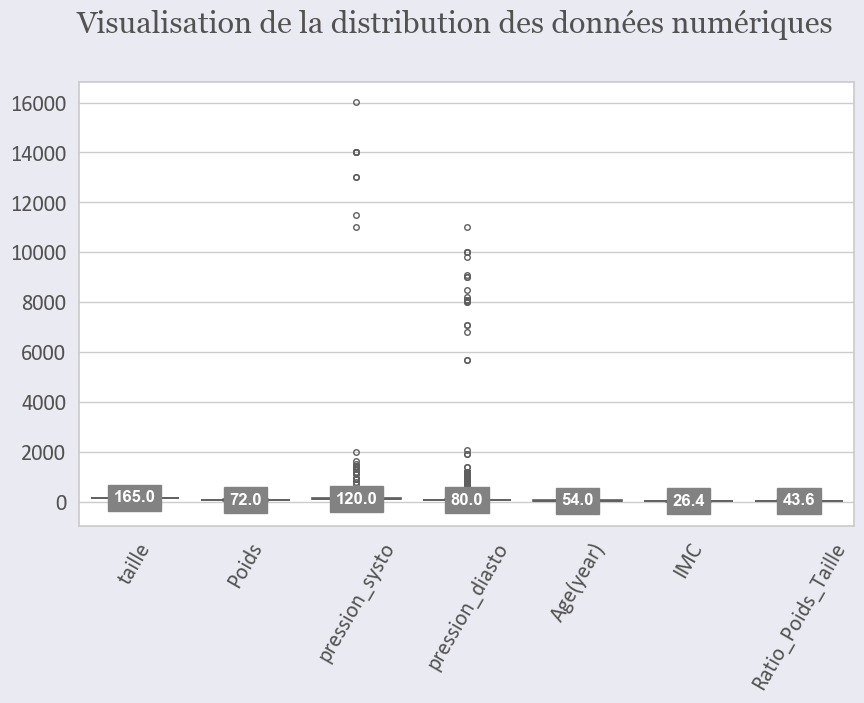

In [18]:
# Boxplot des outliners

var_num = ['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)", 'IMC', "Ratio_Poids_Taille"]
maladie[var_num] = maladie[var_num].apply(pd.to_numeric, errors='coerce', axis=1)

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

x = sns.boxplot(data=maladie,
                       palette='Set3',
                       linewidth=1.2,
                       fliersize=2,
                       order=['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)",'IMC', "Ratio_Poids_Taille"],
                       flierprops=dict(marker='o', markersize=4))

font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

title = 'Visualisation de la distribution des données numériques'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)

for i, box in enumerate(ax.artists):
         col = box.get_facecolor()
         plt.setp(ax.lines[i*6+5], mfc=col, mec=col)

lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    ax.text(
        cat,
        y,
        f'{y}',
        ha='center',
        va='center',
        fontweight='semibold',
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.show()

In [19]:
maladie["IMC"].mean()

27.557610036546496

Suppression des outliers

In [20]:
out_filter = ((maladie["pression_systo"]>250) | (maladie["pression_diasto"]>200))
maladie = maladie[~out_filter]
out_filter2 = ((maladie["pression_systo"] < 0) | (maladie["pression_diasto"] < 0))
maladie = maladie[~out_filter2]
out_filter3 = ((maladie["taille"] > 200))
maladie = maladie[~out_filter3]
out_filter4 = ((maladie["IMC"] > 200))
maladie = maladie[~out_filter4]

C:\Users\rapha\AppData\Local\Temp\ipykernel_800\2417649260.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


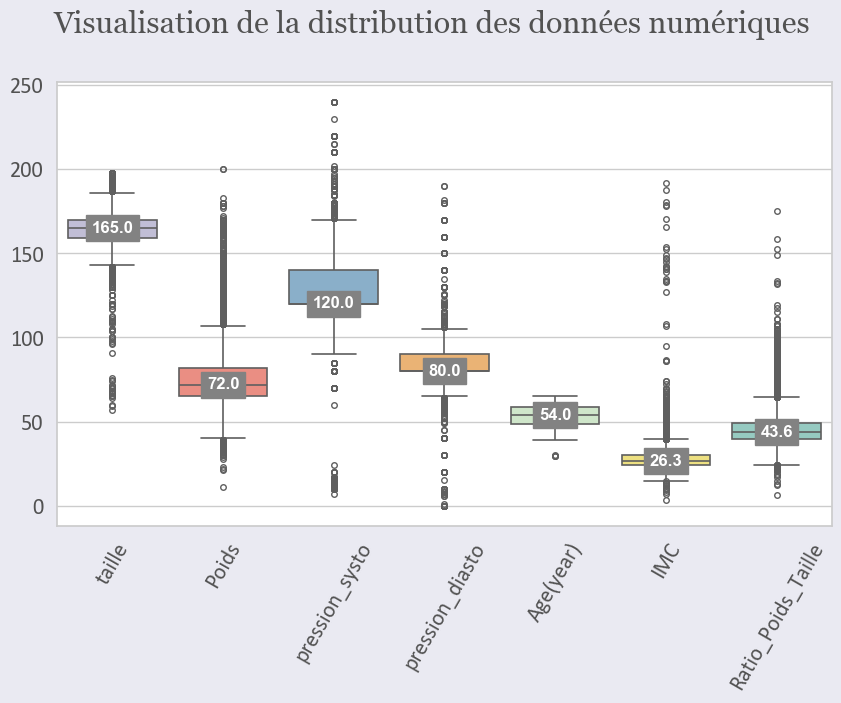

In [21]:
# Boxplot des outliners

var_num = ['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)", 'IMC', "Ratio_Poids_Taille"]
maladie[var_num] = maladie[var_num].apply(pd.to_numeric, errors='coerce', axis=1)

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

x = sns.boxplot(data=maladie,
                       palette='Set3',
                       linewidth=1.2,
                       fliersize=2,
                       order=['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)",'IMC', "Ratio_Poids_Taille"],
                       flierprops=dict(marker='o', markersize=4))

font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

title = 'Visualisation de la distribution des données numériques'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)

for i, box in enumerate(ax.artists):
         col = box.get_facecolor()
         plt.setp(ax.lines[i*6+5], mfc=col, mec=col)

lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    ax.text(
        cat,
        y,
        f'{y}',
        ha='center',
        va='center',
        fontweight='semibold',
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.show()

In [22]:
maladie.shape

(68969, 34)

In [23]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,Ratio_Poids_Taille,cholesterol_eleve,cholesterol_normal,cholesterol_tres eleve,glycemie_1,glycemie_2,glycemie_3,IMC_Categorie_Sous-poids,IMC_Categorie_Normal,IMC_Categorie_Surpoids,IMC_Categorie_Obèse,Age_Categorie_0-18,Age_Categorie_19-35,Age_Categorie_36-50,Age_Categorie_51-70,Age_Categorie_70+,Pression_Arterielle_Categorie_Hypertension,Pression_Arterielle_Categorie_Hypertension Légère,Pression_Arterielle_Categorie_Hypotension,Pression_Arterielle_Categorie_Hypotension Légère,Pression_Arterielle_Categorie_Inconnu,Pression_Arterielle_Categorie_Normale
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18393,1,168.0,62.0,110.0,80.0,1,0,1,0,50.391781,21.967120,36.904762,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,20228,0,156.0,85.0,140.0,90.0,1,0,1,1,55.419178,34.927679,54.487179,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,18857,0,165.0,64.0,130.0,70.0,1,0,0,1,51.663014,23.507805,38.787879,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
3,17623,1,169.0,82.0,150.0,100.0,1,0,1,1,48.282192,28.710479,48.520710,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
4,17474,0,156.0,56.0,100.0,60.0,1,0,0,0,47.873973,23.011177,35.897436,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


# DataViz

Distribution des maladies cardiaques ou non

C:\Users\rapha\AppData\Local\Temp\ipykernel_800\1094622961.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='malade', data=maladie, ax=ax2, palette=palette)
C:\Users\rapha\AppData\Local\Temp\ipykernel_800\1094622961.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(["Arrêt cardiaque", "Normal"])


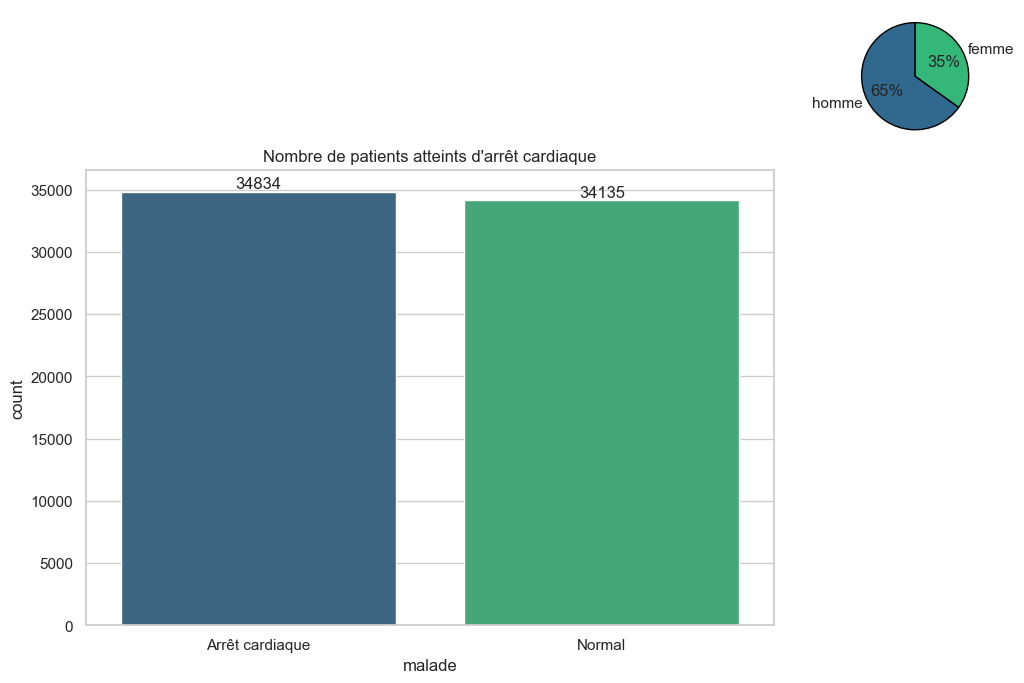

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
gs = plt.GridSpec(4, 4)

# Tracé du graphique principal (histogramme)
ax2 = plt.subplot(gs[1:, :-1])
palette = sns.color_palette("viridis", 2)
sns.countplot(x='malade', data=maladie, ax=ax2, palette=palette)
for i, j in enumerate(maladie['malade'].value_counts().values):
    ax2.text(i, j, str(j), ha='center', va='bottom', fontsize=12)
ax2.set(title="Nombre de patients atteints d'arrêt cardiaque")
ax2.set_xticklabels(["Arrêt cardiaque", "Normal"])

# Tracé du diagramme circulaire (en petit)
ax1 = plt.subplot(gs[0, -1])

gender_labels = label_encoder_sex.inverse_transform(maladie['genre'].unique())
ax1.pie(maladie['genre'].value_counts(), labels=gender_labels, autopct="%1.0f%%", startangle=90, colors=palette, wedgeprops={'edgecolor': 'black'})
plt.show()


C:\Users\rapha\AppData\Local\Temp\ipykernel_800\2492981096.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='malade', data=maladie, ax=ax2, palette="viridis")


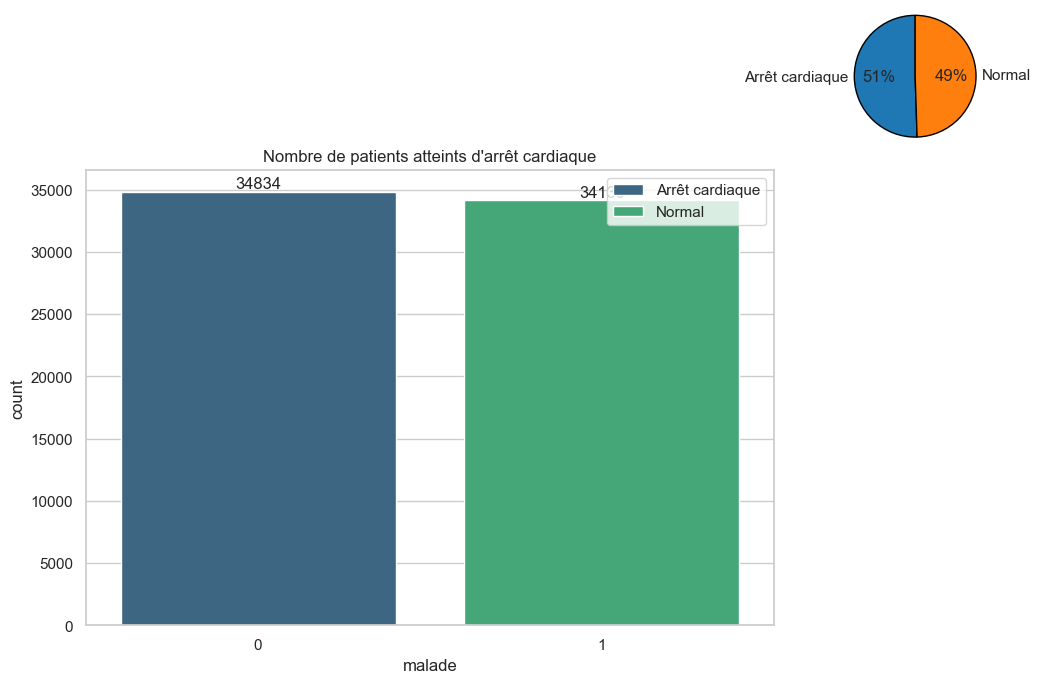

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de la figure et des sous-graphiques
plt.figure(figsize=(12, 8))
gs = plt.GridSpec(4, 4)

# Tracé du graphique principal (histogramme)
ax2 = plt.subplot(gs[1:, :-1])
sns.countplot(x='malade', data=maladie, ax=ax2, palette="viridis")
for i, j in enumerate(maladie['malade'].value_counts().values):
    ax2.text(i, j, str(j), ha='center', va='bottom', fontsize=12)
ax2.set(title="Nombre de patients atteints d'arrêt cardiaque")
ax2.legend(labels=["Arrêt cardiaque", "Normal"])

# Tracé du diagramme circulaire (en petit)
ax1 = plt.subplot(gs[0, -1])
colors = ['#1f77b4', '#ff7f0e']  # Couleurs pour le diagramme circulaire
ax1.pie(maladie['malade'].value_counts(), labels=["Arrêt cardiaque", "Normal"], autopct="%1.0f%%", startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})

# Réglage de l'apparence du deuxième graphique
ax1.axis('equal')  # Pour que le diagramme circulaire soit parfaitement circulaire
plt.show()


In [26]:
# Création de l'histogramme
fig = px.histogram(maladie, x="Age(year)", nbins=30, title="Distribution de l'âge")

# Ajustements esthétiques
fig.update_traces(marker_color='skyblue', marker_line_color='black', marker_line_width=1, opacity=0.7)

# Ajustements de la mise en page
fig.update_layout(xaxis_title="Âge (années)", yaxis_title="Nombre", showlegend=False,
                  bargap=0.05, plot_bgcolor='rgba(0,0,0,0)', margin=dict(l=50, r=50, t=50, b=50))

# Affichage du graphique
fig.show()


NameError: name 'px' is not defined

Distribution de l'âge

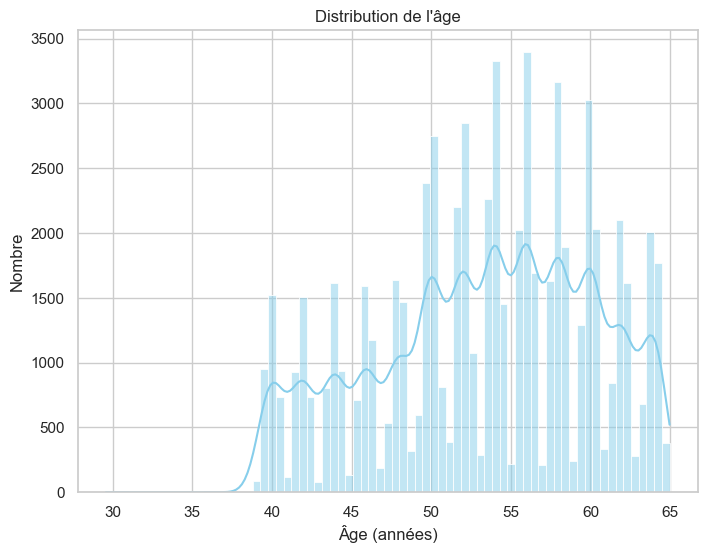

In [ ]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot avec seaborn
ax = plt.subplot(111)  # Utilisation d'un seul subplot pour ce tracé
sns.histplot(maladie['Age(year)'], ax=ax, kde=True, color='skyblue')  # Ajout d'un kernel density estimate (KDE) pour une meilleure visualisation de la distribution
plt.title("Distribution de l'âge")  # Ajout d'un titre descriptif

# Ajout de labels pour les axes
plt.xlabel("Âge (années)")
plt.ylabel("Nombre")

# Ajout de la grille pour une meilleure lisibilité
plt.grid(True)

plt.show()

Répartition par genre

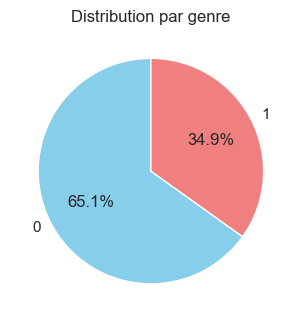

In [ ]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot
plt.subplot(121)  # Utilisation d'un seul subplot pour ce tracé
plt.title("Distribution par genre")  # Ajout d'un titre descriptif

# Création du diagramme circulaire avec des couleurs personnalisées
colors = ['skyblue', 'lightcoral', 'lightgreen']
plt.pie(maladie['genre'].value_counts(), labels=maladie['genre'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)

plt.show()


In [ ]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,fumeur,conso_alco,activite_physique,malade,...,Age_Categorie_19-35,Age_Categorie_36-50,Age_Categorie_51-70,Age_Categorie_70+,Pression_Arterielle_Categorie_Hypertension,Pression_Arterielle_Categorie_Hypertension Légère,Pression_Arterielle_Categorie_Hypotension,Pression_Arterielle_Categorie_Hypotension Légère,Pression_Arterielle_Categorie_Inconnu,Pression_Arterielle_Categorie_Normale
id,,,,,,,,,,,,,,,,,,,,,
0,18393,1,168.0,62.0,110.0,80.0,1,0,1,0,...,False,False,True,False,False,False,False,False,True,False
1,20228,0,156.0,85.0,140.0,90.0,1,0,1,1,...,False,False,True,False,True,False,False,False,False,False
2,18857,0,165.0,64.0,130.0,70.0,1,0,0,1,...,False,False,True,False,False,True,False,False,False,False
3,17623,1,169.0,82.0,150.0,100.0,1,0,1,1,...,False,True,False,False,True,False,False,False,False,False
4,17474,0,156.0,56.0,100.0,60.0,1,0,0,0,...,False,True,False,False,False,False,False,True,False,False


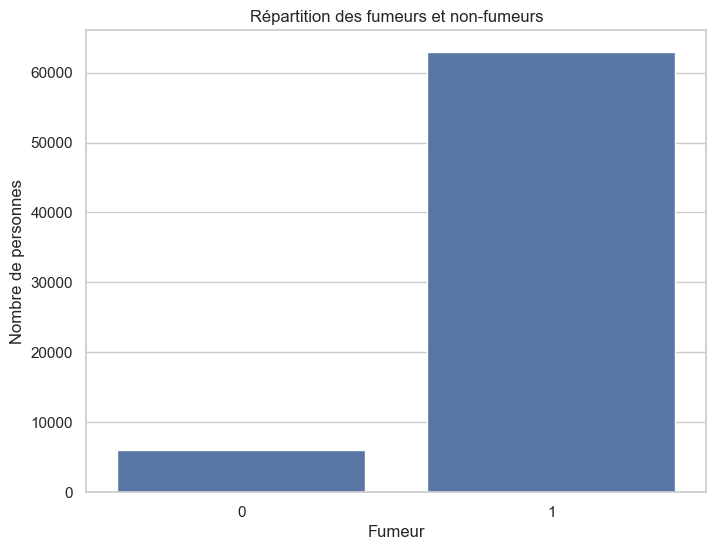

In [ ]:
# Diagramme en barres de fumeurs et non-fumeurs
plt.figure(figsize=(8, 6))
sns.countplot(x='fumeur', data=maladie)
plt.title('Répartition des fumeurs et non-fumeurs')
plt.xlabel('Fumeur')
plt.ylabel('Nombre de personnes')
plt.show()

# Variables d'intérêt

RFE

In [ ]:
#linmodel = LinearRegression()
#rfe1 = RFE(estimator=linmodel,n_features_to_select=7,step=1,verbose=3)
#rfe1.fit(x_train,y_train)
#
#var_sel = rfe1.get_support()
#
#plt.matshow(var_sel.reshape(1,-1), cmap = 'gray_r')
#plt.xlabel('Feature selection')
#plt.yticks([]);

# Modèle IA

KNN

In [28]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,Ratio_Poids_Taille,cholesterol_eleve,cholesterol_normal,cholesterol_tres eleve,glycemie_1,glycemie_2,glycemie_3,IMC_Categorie_Sous-poids,IMC_Categorie_Normal,IMC_Categorie_Surpoids,IMC_Categorie_Obèse,Age_Categorie_0-18,Age_Categorie_19-35,Age_Categorie_36-50,Age_Categorie_51-70,Age_Categorie_70+,Pression_Arterielle_Categorie_Hypertension,Pression_Arterielle_Categorie_Hypertension Légère,Pression_Arterielle_Categorie_Hypotension,Pression_Arterielle_Categorie_Hypotension Légère,Pression_Arterielle_Categorie_Inconnu,Pression_Arterielle_Categorie_Normale
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18393,1,168.0,62.0,110.0,80.0,1,0,1,0,50.391781,21.967120,36.904762,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,20228,0,156.0,85.0,140.0,90.0,1,0,1,1,55.419178,34.927679,54.487179,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,18857,0,165.0,64.0,130.0,70.0,1,0,0,1,51.663014,23.507805,38.787879,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
3,17623,1,169.0,82.0,150.0,100.0,1,0,1,1,48.282192,28.710479,48.520710,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
4,17474,0,156.0,56.0,100.0,60.0,1,0,0,0,47.873973,23.011177,35.897436,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [29]:
data_col = maladie[['Age(year)','taille','Poids','pression_systo','pression_diasto','activite_physique','fumeur','conso_alco','malade','genre', 'cholesterol_eleve','cholesterol_normal','cholesterol_tres eleve',	'glycemie_1',	'glycemie_2'	,'glycemie_3',	'IMC_Categorie_Sous-poids',	'IMC_Categorie_Normal',	'IMC_Categorie_Surpoids',	'IMC_Categorie_Obèse',	'Age_Categorie_0-18',	'Age_Categorie_19-35',	'Age_Categorie_36-50',	'Age_Categorie_51-70',	'Age_Categorie_70+',	'Pression_Arterielle_Categorie_Hypertension',	'Pression_Arterielle_Categorie_Hypertension Légère'	,'Pression_Arterielle_Categorie_Hypotension',	'Pression_Arterielle_Categorie_Hypotension Légère',	'Pression_Arterielle_Categorie_Inconnu',	'Pression_Arterielle_Categorie_Normale']]
data_col.head()

,Age(year),taille,Poids,pression_systo,pression_diasto,activite_physique,fumeur,conso_alco,malade,genre,cholesterol_eleve,cholesterol_normal,cholesterol_tres eleve,glycemie_1,glycemie_2,glycemie_3,IMC_Categorie_Sous-poids,IMC_Categorie_Normal,IMC_Categorie_Surpoids,IMC_Categorie_Obèse,Age_Categorie_0-18,Age_Categorie_19-35,Age_Categorie_36-50,Age_Categorie_51-70,Age_Categorie_70+,Pression_Arterielle_Categorie_Hypertension,Pression_Arterielle_Categorie_Hypertension Légère,Pression_Arterielle_Categorie_Hypotension,Pression_Arterielle_Categorie_Hypotension Légère,Pression_Arterielle_Categorie_Inconnu,Pression_Arterielle_Categorie_Normale
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,50.391781,168.0,62.0,110.0,80.0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,55.419178,156.0,85.0,140.0,90.0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,51.663014,165.0,64.0,130.0,70.0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
3,48.282192,169.0,82.0,150.0,100.0,1,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
4,47.873973,156.0,56.0,100.0,60.0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [30]:
target = data_col['malade']
data = data_col.drop(['malade'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state = 123, test_size = 0.2)

In [ ]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [ ]:
math.sqrt(len(y_test))

117.44786077234443

In [ ]:
param_grid = {
    'n_neighbors': [60, 80, 120],  # ajustez cette plage selon vos besoins
    'p': [1, 2],  # Norme de distance (1 pour la distance de Manhattan, 2 pour la distance euclidienne)
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Créer un classifieur KNN
knn = KNeighborsClassifier()

# Effectuer une recherche par validation croisée
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
grid_search.fit(x_train[:5000], y_train[:5000])
#grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [60, 80, 120], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleurs estimateurs:", grid_search.best_estimator_)

Meilleurs paramètres: {'algorithm': 'ball_tree', 'n_neighbors': 80, 'p': 1, 'weights': 'distance'}
Meilleurs estimateurs: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=80, p=1,
                     weights='distance')


In [ ]:
# Entraîner le modèle avec les meilleurs paramètres
best_knn = grid_search.best_estimator_
best_knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=80, p=1,
                     weights='distance')

In [ ]:
# Prédire les étiquettes de test
y_train_pred = best_knn.predict(x_train)
y_test_pred = best_knn.predict(x_test)

In [ ]:
# Calculer la précision
accuracy = accuracy_score(y_train, y_train_pred)
print("Précision du modèle train avec les meilleurs paramètres:", accuracy)
accuracy = accuracy_score(y_test, y_test_pred)
print("Précision du modèle test avec les meilleurs paramètres:", accuracy)

Précision du modèle train avec les meilleurs paramètres: 0.9998006343452651
Précision du modèle test avec les meilleurs paramètres: 0.7204581702189358


In [ ]:
print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27898
           1       1.00      1.00      1.00     27277

    accuracy                           1.00     55175
   macro avg       1.00      1.00      1.00     55175
weighted avg       1.00      1.00      1.00     55175



In [ ]:
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6936
           1       0.74      0.68      0.71      6858

    accuracy                           0.72     13794
   macro avg       0.72      0.72      0.72     13794
weighted avg       0.72      0.72      0.72     13794



In [ ]:
cm = confusion_matrix(y_train,y_train_pred)
cm2 = confusion_matrix(y_test,y_test_pred)

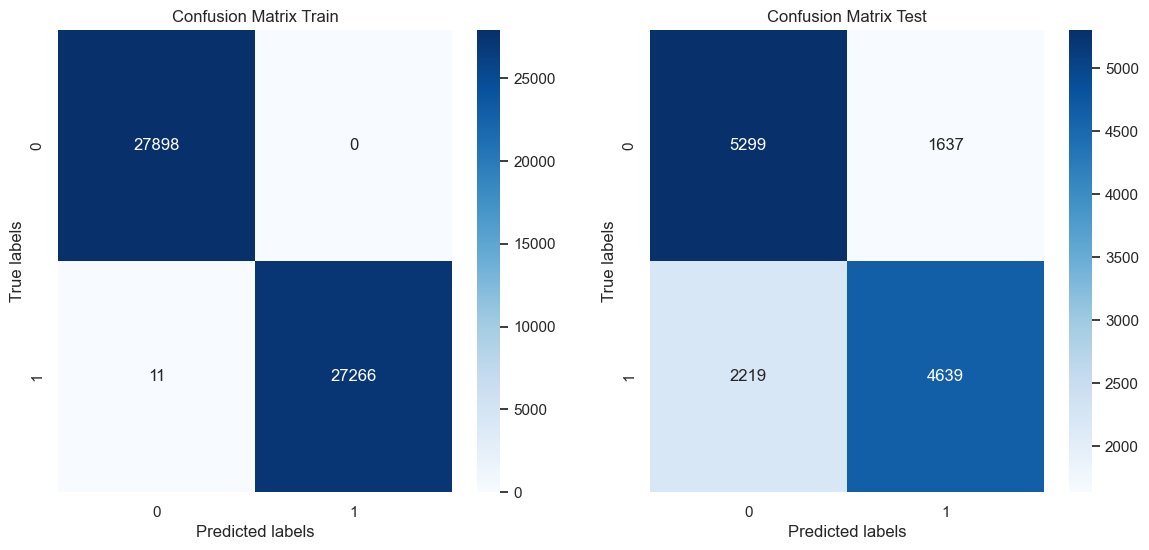

In [ ]:
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Train')
plt.subplot(122)
sns.heatmap(cm2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test')
plt.show()

In [ ]:
TN = cm2[0][0]
FP = cm2[0][1]
FN = cm2[1][0]
TP = cm2[1][1]

score = TN/(TN+FP)
display(score)

0.7639850057670127

In [ ]:
x_train.shape[1]

30

In [ ]:
from sklearn.model_selection import cross_val_score

# Mesurer les performances du modèle initial
initial_score = np.mean(cross_val_score(best_knn, x_train, y_train, cv=5))

# Initialiser une liste pour stocker les changements de performance
feature_importances = []

# Mesurer l'impact de chaque variable
for feature in x_train.columns:
    X_temp = x_train.drop(columns=[feature])  # Supprimer la caractéristique actuelle
    new_score = np.mean(cross_val_score(best_knn, X_temp, y_train, cv=5))
    importance = initial_score - new_score
    feature_importances.append((feature, importance))


# Trier le résultat par ordre décroissant d'importance
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Afficher les importances
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


NameError: name 'np' is not defined

On cherche à déterminer si le patient est réellement malade. Ce qui importe ici, c'est de savoir s'il est effectivement malade et non pas s'il ne l'est pas.

SVM

In [31]:
pca4 = PCA(n_components=0.99)
X_train_pca = pca4.fit_transform(x_train)
X_test_pca = pca4.transform(x_test)

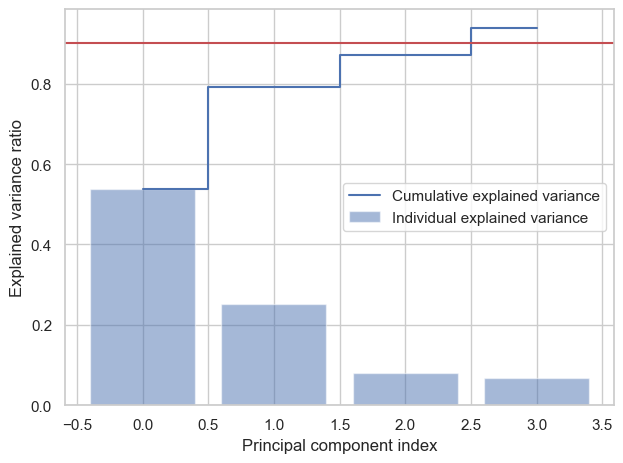

In [32]:
pca3 = PCA(n_components=0.9)
pca3.fit_transform(x_train)
exp_var_pca3 = pca3.explained_variance_ratio_
cumulTotal = np.cumsum(exp_var_pca3)
cumulTotal
plt.bar(range(0,len(exp_var_pca3)), exp_var_pca3, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cumulTotal)), cumulTotal, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.axhline(y=0.9, color='r', linestyle='-')
plt.show()

In [33]:
svc1 = SVC(C=1, kernel='linear', verbose=True)
svc1.fit(X_train_pca[:100],y_train[:100])
display(svc1.score(X_test_pca,y_test))

[LibSVM]

0.7026243294185878

In [34]:
svc2 = SVC(C=1, kernel='linear')
svc2.fit(x_train[:1000],y_train[:1000])
display(svc2.score(x_test,y_test))


0.7146585471944323

In [35]:
y_pred2 = svc2.predict(x_test)
y_train2 = svc2.predict(x_train)
print(classification_report(y_true=y_test, y_pred=y_pred2   ))
conf_matrix1 = confusion_matrix(y_true=y_test, y_pred=y_pred2)

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      6936
           1       0.77      0.61      0.68      6858

    accuracy                           0.71     13794
   macro avg       0.72      0.71      0.71     13794
weighted avg       0.72      0.71      0.71     13794



array([[5662, 1274],
       [2662, 4196]], dtype=int64)

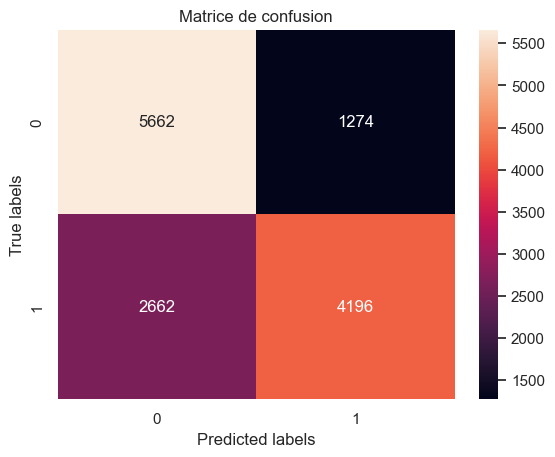

In [36]:
sns.heatmap(conf_matrix1, annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
display(conf_matrix1)

In [37]:
TN =conf_matrix1[0][0]
FP = conf_matrix1[0][1]
FN =conf_matrix1[1][0]
TP = conf_matrix1[1][1]

score = TN/(TN+FP)
display(score)

0.816320645905421

In [38]:
param_grid = {
    'C': [1, 2,3, 5, 7, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
svc = SVC()


In [39]:
# Créer un objet GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)



In [40]:
# Effectuer la recherche sur la grille avec les données d'entraînement
grid_search.fit(x_train[:5000], y_train[:5000])

KeyboardInterrupt: 

In [ ]:
#Afficher les meilleurs paramètres et le score correspondant
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score (cross-validation):", grid_search.best_score_)
# Obtenir le modèle avec les meilleurs paramètres
best_svc = grid_search.best_estimator_
# Évaluer le modèle sur les données de test
test_score = best_svc.score(x_test, y_test)
print("Score sur les données de test:", test_score)

Meilleurs paramètres: {'C': 5, 'kernel': 'linear'}
Meilleur score (cross-validation): 0.7227999999999999


Score sur les données de test: 0.7152385094968827


In [ ]:
svc3 = best_svc
svc3.fit(x_train[:1000],y_train[:1000])
display(svc3.score(x_test,y_test))

0.7142960707554009

In [ ]:
y_pred2 = svc3.predict(x_test)
print(classification_report(y_true=y_test, y_pred=y_pred2   ))
conf_matrix2 = confusion_matrix(y_true=y_test, y_pred=y_pred2)

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      6936
           1       0.77      0.61      0.68      6858

    accuracy                           0.71     13794
   macro avg       0.72      0.71      0.71     13794
weighted avg       0.72      0.71      0.71     13794



array([[5664, 1272],
       [2669, 4189]], dtype=int64)

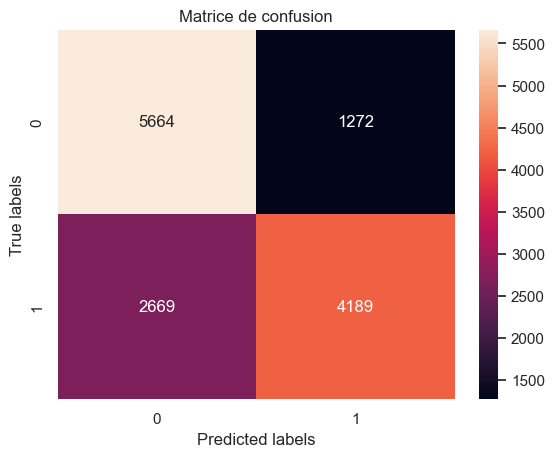

In [ ]:
sns.heatmap(conf_matrix2, annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
display(conf_matrix2)

In [ ]:
TN =conf_matrix2[0][0]
FP = conf_matrix2[0][1]
FN =conf_matrix2[1][0]
TP = conf_matrix2[1][1]

score = TN/(TN+FP)
display(score)

0.8166089965397924

In [ ]:
coefficients = svc3.coef_.ravel()

# Créer un DataFrame pour afficher les variables et leurs importances
feature_importance_df = pd.DataFrame({'Variable': x_train.columns, 'Importance': coefficients})

# Trier le DataFrame par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)

# Afficher le DataFrame avec les importances
print(feature_importance_df)

                                      Variable  Importance
24  Pression_Arterielle_Categorie_Hypertension    1.465155
11                      cholesterol_tres eleve    1.143636
17                      IMC_Categorie_Surpoids    0.104575
12                                  glycemie_1    0.092833
21                         Age_Categorie_36-50    0.062222


# Decision Tree

In [ ]:
model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=861)
model_tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=861)

In [ ]:
y_pred_tree = model_tree.predict(x_train)
y_pred_tree1 = model_tree.predict(x_test)
cm_tree = pd.crosstab(y_train, y_pred_tree, rownames=['Classe réelle (train)'], colnames=['Classe prédite (train)'], margins=True);
cm_tree1 = pd.crosstab(y_test, y_pred_tree1, rownames=['Classe réelle (train)'], colnames=['Classe prédite (train)'], margins=True);

display(cm_tree)
display(cm_tree1)

Classe prédite (train),0,1,All
Classe réelle (train),,,
0,21157,6741,27898
1,7633,19644,27277
All,28790,26385,55175


Classe prédite (train),0,1,All
Classe réelle (train),,,
0,5154,1782,6936
1,1998,4860,6858
All,7152,6642,13794


In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred_tree1   ))
conf_matrix1 = confusion_matrix(y_true=y_test, y_pred=y_pred_tree1)

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      6936
           1       0.73      0.71      0.72      6858

    accuracy                           0.73     13794
   macro avg       0.73      0.73      0.73     13794
weighted avg       0.73      0.73      0.73     13794



In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialisation du classificateur
clf = DecisionTreeClassifier()

In [ ]:
# Création de l'objet GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustement du modèle
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
# Affichage des meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)

# Evaluation des performances sur l'ensemble de test
accuracy = grid_search.best_estimator_.score(x_test, y_test)
print("Accuracy:", accuracy)

Meilleurs paramètres: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy: 0.7259678120922141


In [ ]:
model_tree2 = grid_search.best_estimator_
model_tree2.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=5)

In [ ]:
y_pred_tree2 = model_tree2.predict(x_train)
y_pred_tree21 = model_tree2.predict(x_test)
cm_tree2 = pd.crosstab(y_train, y_pred_tree2, rownames=['Classe réelle (train)'], colnames=['Classe prédite (train)'], margins=True);
cm_tree21 = pd.crosstab(y_test, y_pred_tree21, rownames=['Classe réelle (train)'], colnames=['Classe prédite (train)'], margins=True);

display(cm_tree2)
display(cm_tree21)

Classe prédite (train),0,1,All
Classe réelle (train),,,
0,22065,5833,27898
1,8981,18296,27277
All,31046,24129,55175


Classe prédite (train),0,1,All
Classe réelle (train),,,
0,5447,1489,6936
1,2291,4567,6858
All,7738,6056,13794


In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred_tree21   ))
conf_matrix1 = confusion_matrix(y_true=y_test, y_pred=y_pred_tree21)

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6936
           1       0.75      0.67      0.71      6858

    accuracy                           0.73     13794
   macro avg       0.73      0.73      0.72     13794
weighted avg       0.73      0.73      0.72     13794



In [ ]:
importances = model_tree.feature_importances_

# Créer un DataFrame pour afficher les variables et leurs importances
feature_importance_df = pd.DataFrame({'Variable': x_train.columns, 'Importance': importances})

# Trier le DataFrame par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher le DataFrame avec les importances
print(feature_importance_df)

                                             Variable  Importance
3                                      pression_systo    0.703933
0                                           Age(year)    0.146166
11                             cholesterol_tres eleve    0.065627
2                                               Poids    0.025675
1                                              taille    0.009676
4                                     pression_diasto    0.009445
14                                         glycemie_3    0.008366
5                                   activite_physique    0.008331
10                                 cholesterol_normal    0.006114
6                                              fumeur    0.004135
24         Pression_Arterielle_Categorie_Hypertension    0.003765
13                                         glycemie_2    0.002057
28              Pression_Arterielle_Categorie_Inconnu    0.001407
12                                         glycemie_1    0.001145
16        

In [ ]:
importances = model_tree2.feature_importances_

# Créer un DataFrame pour afficher les variables et leurs importances
feature_importance_df = pd.DataFrame({'Variable': x_train.columns, 'Importance': importances})

# Trier le DataFrame par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher le DataFrame avec les importances
print(feature_importance_df)

                                             Variable  Importance
3                                      pression_systo    0.781398
0                                           Age(year)    0.123830
11                             cholesterol_tres eleve    0.071819
14                                         glycemie_3    0.007231
25  Pression_Arterielle_Categorie_Hypertension Légère    0.004241
9                                   cholesterol_eleve    0.002852
5                                   activite_physique    0.002014
2                                               Poids    0.001987
16                               IMC_Categorie_Normal    0.001907
4                                     pression_diasto    0.001156
1                                              taille    0.001104
12                                         glycemie_1    0.000462
28              Pression_Arterielle_Categorie_Inconnu    0.000000
27   Pression_Arterielle_Categorie_Hypotension Légère    0.000000
26        